In [10]:
from ps2d_for_sbi import *
from utility import *
from models import * 
from dataloader import *
my_module_path = os.path.join("./", '21cm-wrapper')
sys.path.append(my_module_path)
from Leaf import *
import tqdm

In [7]:
# hyperparams
data_path = "./data/"
batch_size = 8
epochs = 120
train_test_data_ration = 0.95

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 6e-4,
}

loss = torch.nn.MSELoss
loss_params = {}

norm_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)


# transform trainingsdata
# perhaps add check if file is there: continue + override option in the future
#convert_to_torch(path = data_path, prefix="run", redshift_cutoff=600, debug=False, statistics=True)

# load data
train_data = DataHandler(path=data_path, prefix="batch", load_to_ram=False,
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)
test_data = DataHandler(path=data_path, prefix="batch", load_to_ram=False,
                         split = train_test_data_ration, training_data = False,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False,
                             num_workers = 2, pin_memory = True, prefetch_factor=2)

# init model
model = ModelHandler(Model = Summary_net_lc_smol,
                     Training_data=train_dataloader, Test_data=test_dataloader, device='cpu')

In [ ]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

In [5]:
# take closer look at test
ModelHandler.test_specific(test_dataloader, model.Model, loss(**loss_params), 1, denormalize=test_data.denormalize)

# save the model
#model.save_model(name = "summary_net.pt")

loss: 9771.8095703125
 pred: tensor([[4.7056e+00, 2.0909e-01, 4.1509e+01, 9.7214e+02, 5.0531e+00, 1.9355e+02],
        [3.2670e+00, 3.0016e-01, 4.0285e+01, 2.0903e+02, 4.9114e+00, 2.1090e+02],
        [6.4987e+00, 3.5049e-01, 3.9270e+01, 7.9099e+02, 4.4319e+00, 2.7894e+01],
        [6.2723e+00, 2.3508e-01, 3.9357e+01, 1.3976e+02, 5.1864e+00, 1.0977e+02],
        [5.5044e+00, 2.2245e-01, 3.9430e+01, 9.9683e+02, 4.3380e+00, 7.5367e+01],
        [4.3802e+00, 3.3234e-01, 4.1685e+01, 1.1081e+03, 4.9861e+00, 9.9697e+01],
        [4.2998e+00, 2.6039e-01, 4.1193e+01, 9.4134e+02, 5.1101e+00, 1.4847e+02],
        [4.0433e+00, 2.7417e-01, 4.1350e+01, 1.1188e+03, 4.9679e+00, 1.9201e+02]])
 truth: tensor([[8.6254e+00, 2.0445e-01, 4.1475e+01, 1.0218e+03, 4.9343e+00, 2.0373e+02],
        [1.4387e+00, 2.5871e-01, 4.0479e+01, 1.9545e+02, 4.9306e+00, 2.0469e+02],
        [9.9281e+00, 3.7896e-01, 3.8860e+01, 1.2317e+03, 4.0699e+00, 2.0282e+01],
        [7.7567e+00, 2.4295e-01, 3.9419e+01, 2.9904e+02, 5.1

In [16]:
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# define model hyperparemeter
user_params = {
"HII_DIM": 40,
"BOX_LEN": 160,
"N_THREADS": 2,
"USE_INTERPOLATION_TABLES": True,
"PERTURB_ON_HIGH_RES": True
}

flag_options = {
"INHOMO_RECO": True,
"USE_TS_FLUCT": True
}

#simparams = p21c.outputs.LightCone.read("./data/run_36690")
# load the simulator class
Leaf_simulator = Leaf(debug=True, user_params=user_params, flag_options=flag_options, redshift = 5.5)

# define the prior ranges (only need for denormalization!)
prior_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)

# define the prior (uniform prior in this case)
prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)))

# define the simulator
def simulation(theta):
    M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR = theta
    cosmo_params = {
        "OMm": OMm.item()
        }
    astro_params = {
        "L_X": L_X.item(),
        "NU_X_THRESH": NU_X_THRESH.item(),
        "ION_Tvir_MIN": ION_Tvir_MIN.item(),
        "HII_EFF_FACTOR": HII_EFF_FACTOR.item(),
        "INHOMO_RECO": True
    }
    global_params = {
        "M_WDM": M_WDM.item()
    }


    return Model.fast_forward(torch.as_tensor(Leaf_simulator.run_lightcone(
        save = False, sanity_check = True, filter_peculiar = False, debug=False,
        astro_params = astro_params, global_params = global_params, cosmo_params = cosmo_params).brightness_temp, dtype=torch.float32))


def simulator(theta: torch.FloatTensor, Model: object, threads: int = 1):
    tshape = theta.shape
    schwimmhalle = Pool(max_workers=threads, max_tasks_per_child=1, mp_context=get_context('spawn'))
    runner = [params for params in theta]
    result = []
    with alive_bar(len(runner), force_tty=True) as bar: 
        with schwimmhalle as p:
            data = p.map(simulation, runner)
            for dat in data:
                lc_bt = future.result()

                dat.add_done_callback(bar())
    return data


Set initial parameters...


In [4]:
# check if simulator is working
#prepare_for_sbi(prior = prior, simulator = simulation)

Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 124.12916564941406
    ION_Tvir_MIN    : 73053.13834711722
    L_X             : 4.586363852269434e+41
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 1066.726806640625
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 50.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 73053.13834711722
    t_STAR          : 0.5
    
cosmo_params: CosmoParams:
    OMb        : 0.04897468161869667
    OMm        : 0.2648005783557892
    POWER_INDEX: 0.9665
    SIGMA_8    : 0.8102
    hlittle    : 0.6766

KeyboardInterrupt: 

|                                        | ▁▃▅ 0/68 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 68/68 [100%] in 3.8s (17.63/s)       
|████████████████████████████████████████| 4/4 [100%] in 0.4s (7.06/s)          


Drawing 10000 posterior samples: 10511it [00:00, 87705.71it/s]            
Drawing 10000 posterior samples: 11045it [00:00, 66775.96it/s]                          
Drawing 10000 posterior samples: 11288it [00:00, 80501.43it/s]            


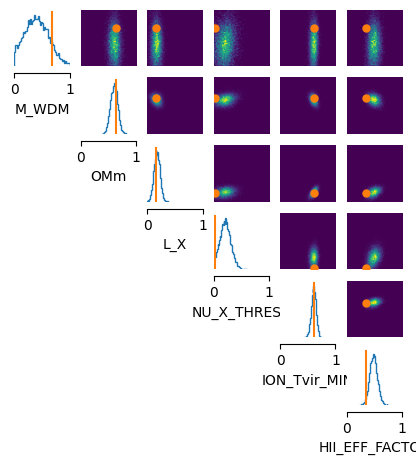

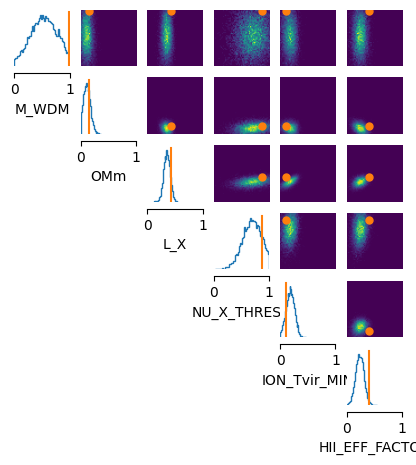

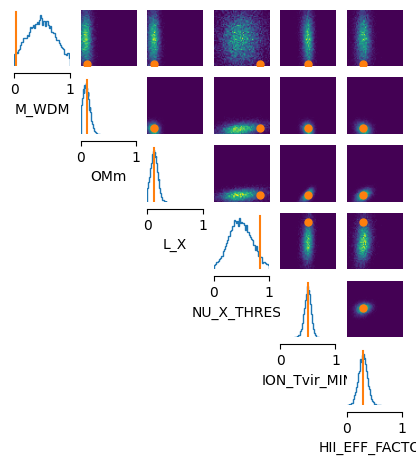

In [8]:
### SNPE ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()

# load the summary model
model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

# do inference using a freezed summary model
x,y = model.full_inference(train_dataloader)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()
# infere test data
x,y = model.full_inference(test_dataloader)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_estimator, prior=prior)
for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    posterior_samples = posterior.sample((10000,), x=x[idx,:])

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y[idx]

    )
    
    fig.savefig(f"./NPE_{i}.png", dpi=300)

In [17]:
# define point of interest
# [M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR]
x_o = torch.tensor([2, 0.30964144154550644, 40.0, 500.0, 4.69897, 30.0], dtype=torch.float32)

# A PPC is performed after we trained or neural posterior
posterior.set_default_x(x_o)

# We draw theta samples from the posterior. This part is not in the scope of SBI
if __name__ == '__main__':
    posterior_samples = posterior.sample((5000,))

# We use posterior theta samples to generate x data
    x_pp = torch.as_tensor(simulator(theta = posterior_samples, Model = model, threads=6))

# We verify if the observed data falls within the support of the generated data
_ = analysis.pairplot(
    samples=x_pp,
    points=x_o
)

Drawing 5000 posterior samples: 5009it [00:03, 1262.64it/s]                          


|                                        | ▂▄▆ 0/5000 [0%] in 0s (~0s, 0.0/s) 

Process SpawnProcess-8:
Traceback (most recent call last):
Process SpawnProcess-9:
Traceback (most recent call last):
Process SpawnProcess-10:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'simulation' on <module '__main__' (built-in)>
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args,

on 0: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x705fb3fc3240>


on 0: Traceback (most recent call last):
  File "/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()


on 0:   File "/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)


on 0:   File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)


on 0:           ^^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):


on 0:            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/multiprocessing/connection.py", line 935, in wait
    ready = selector.select(timeout)


on 0:             ^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)


on 0:                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^


on 0: KeyboardInterrupt:


|⚠︎                                       | (!) 0/5000 [0%] in 8.2s (0.00/s)     


BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

|                                        | ▁▃▅ 0/68 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 68/68 [100%] in 3.6s (19.17/s)       
 Training neural network. Epochs trained: 27

|████████████████████████████████████████| 4/4 [100%] in 0.4s (8.11/s)          




Generating 10 MCMC inits with 10

Generating 10 MCMC inits with 10
                         workers.: 100%|██████████| 10/10 [00:00<00:00, 52.34it/s]


















































































































































































































































































































































































































































































































































































































































































































































































































































































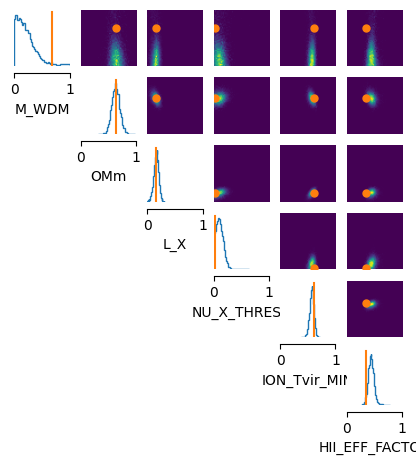

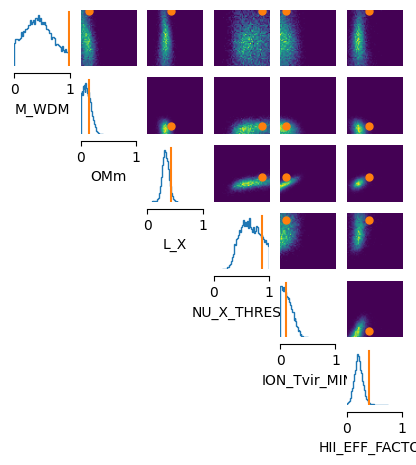

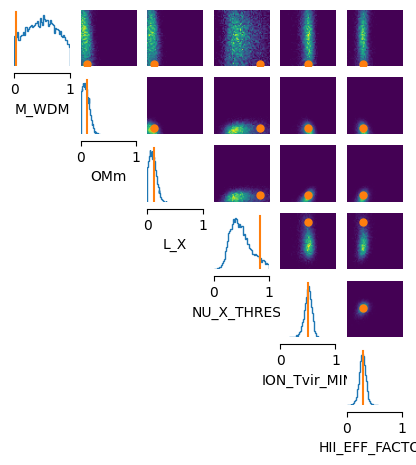

In [99]:
### SNLE ###

from sbi.utils.get_nn_models import (
    likelihood_nn,
)  

# load the summary model
model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

# do inference using a freezed summary model
x,y = model.full_inference(train_dataloader)

# train the maf
inference = SNLE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()
# infere test data
x,y = model.full_inference(test_dataloader)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_estimator, prior=prior)
for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    posterior_samples = posterior.sample((10000,), x=x[idx,:], num_workers=10, method="slice_np_vectorized", num_chains=10)

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y[idx]

    )
    
    fig.savefig(f"./NLE_{i}.png", dpi=300)

In [103]:
1> 0.5 > 0

True

In [87]:
import timeit, os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

def noise1(data):
    dshape = data.shape
    data += torch.normal(torch.full(dshape,0, dtype=torch.float32),1)
    return data

def noise2(data):
    dshape = data.shape
    for i in range(dshape[0]):
        for j in range(dshape[1]):
            for k in range(dshape[2]):
                data[i,j,k] += torch.normal(torch.zeros((1)),1).item()
    return data

In [88]:
data = torch.rand((100,100,100))
%timeit noise1(data)

19 ms ± 223 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1]:
train_data.denormalize

NameError: name 'train_dataloader' is not defined

In [75]:
torch.__config__.show()

'PyTorch built with:\n  - GCC 9.3\n  - C++ Version: 201703\n  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v3.3.6 (Git Hash 86e6af5974177e513fd3fee58425e1063e7f1361)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - LAPACK is enabled (usually provided by MKL)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 12.1\n  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90\n  - CuDNN 8.9.2\n  - Magma 2.6.1\n  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=8.9.2, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-version=11 -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG